# Fase de Modelización 

## Carga del modelo MovilNet

En este primer punto vamos a cargar el modelo MovilNet para iniciar la fase de entrenamiento del modelo con los datos obtenidos en la fase de preanalisis y resolución. Luego probaremos una segunda parte con una CNN creada desde cero para contrastar resultados

### 1. Importamos las librerias que necesitamos para instanciar el modelo 

In [1]:
%run imports.py
from funciones import *

In [3]:
df_model = pd.read_csv("output/df_homogenized.csv")
df_model.head()


,photo_id,label
0,vDEzOHKSOzGoA2Es7FuI_Q,outside
1,h3Yu055wITTBxDyn_9OJ7g,drink
2,SXUVCpXnFVOAupFAknNR_w,inside
3,SaflOiQyfFSdTTGNDGzw4Q,drink
4,kukOAeWgmWV4rZtryqBZzA,drink


In [4]:
df_model.shape

(13325, 2)

In [5]:
df_model["path_files"]= create_path(df_model)

Procesando rutas: 100%|██████████| 13325/13325 [00:08<00:00, 1551.59it/s]

13325 fotos correctas 0 fotos no leidas/invalidas


In [6]:
from Recursos.monitor_resources import *
print_ram_usage()
print_gpu_usage()

=== RAM Usage ===
Total RAM: 15.95 GB
Available RAM: 6.35 GB
Used RAM: 9.60 GB
RAM Usage Percentage: 60.2%
=== GPU 0 (NVIDIA GeForce GTX 1660) ===
  Load: 32.0%
  Free Memory: 4.72 GB
  Used Memory: 1.11 GB
  Total Memory: 6.00 GB
  Temperature: 46.0 °C


In [7]:
df_model = df_model.reindex(columns=["photo_id", "path_files", "label"])
df_model.head()

,photo_id,path_files,label
0,vDEzOHKSOzGoA2Es7FuI_Q,photos\vDEzOHKSOzGoA2Es7FuI_Q.jpg,outside
1,h3Yu055wITTBxDyn_9OJ7g,photos\h3Yu055wITTBxDyn_9OJ7g.jpg,drink
2,SXUVCpXnFVOAupFAknNR_w,photos\SXUVCpXnFVOAupFAknNR_w.jpg,inside
3,SaflOiQyfFSdTTGNDGzw4Q,photos\SaflOiQyfFSdTTGNDGzw4Q.jpg,drink
4,kukOAeWgmWV4rZtryqBZzA,photos\kukOAeWgmWV4rZtryqBZzA.jpg,drink


In [8]:
# Cargado de Imagenes y Formateo a (n, 244, 244, 3)
images, labels = image_label_load(df_model)

# Codificar las etiquetas
label_encoder = LabelEncoder()  # Instancia del encoder 
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded, num_classes=5)  # Especificar 5 clases
 
print(f"Shape of images: {images.shape}")
print(f"Shape of labels encoded: {labels_encoded.shape}")


Codificando imagenes: 13325it [01:49, 121.60it/s]


Shape of images: (13325, 244, 244, 3)
Shape of labels encoded: (13325, 5)


In [8]:
# Carga del MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(244,244,3))

# Congelar capas base del modelo -> Conserva los pesos establecidos por el aprendizaje de imagenet
base_model.trainable = False 

#Añadimos capas superiores para ajustar el modelo a nuestro caso concreto: 
x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Capa Dropout
predictions = Dense(5, activation='softmax')(x)  # Ajuste para 5 clases (menu, outside, drink, inside, food)
# Instancia del MobileNetV2 + capas superiores 
model = Model(inputs=base_model.input, outputs=predictions)

# Compilacion del modelo en conjunto: 
model.compile(optimizer ='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


C:\Users\varel\AppData\Local\Temp\ipykernel_20960\4158362402.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(244,244,3))


In [9]:
# Train/Test split -> Division  de conjuntos de datos en entrenamiento y validacion 
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.25, random_state=41)
# Data Augmentation --> para ganar mas variedad de datos a la hora de entrenar 
"""
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
"""
                ### HIPER-PARAMETROS DE DATA AUGMENTATION PARA ENTRENAMIENTO ###
# datagen = ImageDataGenerator()
# Ajustamos el generador de datos al conjunto de entrenamiento 
# datagen.fit(X_train)

"\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip=True,\n    fill_mode='nearest'\n"

In [10]:
# Numero de pasos por epoch
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
# Entrenar el modelo
history = model.fit(X_train, y_train, batch_size=batch_size,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.7872 - loss: 0.5814 - val_accuracy: 0.7989 - val_loss: 0.5451
Epoch 2/10
  1/312 ━━━━━━━━━━━━━━━━━━━━ 2:07 409ms/step - accuracy: 0.7778 - loss: 0.5135

c:\Users\varel\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


312/312 ━━━━━━━━━━━━━━━━━━━━ 149s 477ms/step - accuracy: 0.7778 - loss: 0.5135 - val_accuracy: 0.7992 - val_loss: 0.5439
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 609s 2s/step - accuracy: 0.7978 - loss: 0.5644 - val_accuracy: 0.8016 - val_loss: 0.5409
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 155s 495ms/step - accuracy: 0.7778 - loss: 0.9867 - val_accuracy: 0.8031 - val_loss: 0.5397
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.8080 - loss: 0.5316 - val_accuracy: 0.8040 - val_loss: 0.5248
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 146s 469ms/step - accuracy: 0.6667 - loss: 0.7579 - val_accuracy: 0.8070 - val_loss: 0.5227
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.8079 - loss: 0.5147 - val_accuracy: 0.7998 - val_loss: 0.5301
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 145s 466ms/step - accuracy: 0.7778 - loss: 0.6482 - val_accuracy: 0.7998 - val_loss: 0.5330
Epoch 9/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.8102 - loss: 0.5274 - val_acc

In [11]:
model.save("Modelo_dropout_13k_entrenado.keras")

105/105 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step
F1-score: 0.79291402734911
Accuracy: 0.7968187274909964
              precision    recall  f1-score   support

       drink       0.77      0.63      0.69       509
        food       0.75      0.85      0.79       464
      inside       0.82      0.86      0.84      1368
        menu       0.87      0.92      0.89       502
     outside       0.73      0.61      0.66       489

    accuracy                           0.80      3332
   macro avg       0.79      0.77      0.78      3332
weighted avg       0.79      0.80      0.79      3332



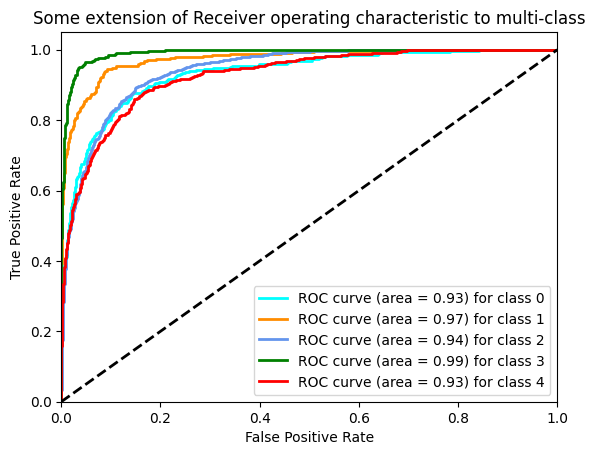

In [12]:
model = load_model("Streamlit/Modelo_dropout_13k_entrenado.keras")

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


# Calcular el F1-score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f'F1-score: {f1}')

# Calcular el accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Generar el reporte de clasificación
report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)
print(report)

# Generar la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear todas las curvas ROC
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0]) # apuntar 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()